In [0]:
# mount Google Drive root
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
5.3.0


## 1.2: VAE with CUFS

In [0]:
import torch
from torch.autograd import Variable
import numpy as np
import os
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
import torchvision.utils as vutils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

opt_outf = "gdrive/My Drive/CIS680/HW3/recon_images/"
try:
    os.makedirs(opt_outf)
except OSError:
    pass


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
      
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)      

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=64):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar


def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD  
  

batch_size = 94

epochs = 1000

# Load Data
dataset = datasets.ImageFolder(root='gdrive/My Drive/CIS680/HW3/cufs/', transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), 
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

vae = VAE(image_channels=3).to(device)

optimizer = optim.Adam(vae.parameters(), lr=0.0001)

loss_list = []

for epoch in range(epochs):
  for idx, (images, _) in enumerate(dataloader):
    images = images.to(device)
    recon_images, mu, logvar = vae(images)
    loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  loss_list.append(loss.data[0]/batch_size)
  
  if(epoch%100 == 0):
    to_print = "Epoch[{}/{}] Loss: {:.3f} , {:.3f} , {:.3f}".format(epoch+1, epochs, loss.data[0]/batch_size, bce.data[0]/batch_size, kld.data[0]/batch_size)
    print(to_print)
    
  if(epoch%250==0 or epoch==999):
    vutils.save_image(recon_images.detach(), '%s/recon_images_epoch_%03d.png' % (opt_outf, epoch), normalize=True)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:151: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch[1/1000] Loss: 8524.078 , 8524.078 , 0.000
Epoch[101/1000] Loss: 5184.874 , 5182.937 , 1.937
Epoch[201/1000] Loss: 4683.226 , 4680.530 , 2.695
Epoch[301/1000] Loss: 4175.640 , 4172.262 , 3.378
Epoch[401/1000] Loss: 3687.904 , 3682.953 , 4.950
Epoch[501/1000] Loss: 3073.507 , 3065.706 , 7.801
Epoch[601/1000] Loss: 2706.280 , 2694.710 , 11.570
Epoch[701/1000] Loss: 2382.597 , 2366.903 , 15.694
Epoch[801/1000] Loss: 2236.130 , 2216.464 , 19.666
Epoch[901/1000] Loss: 1928.785 , 1903.954 , 24.831


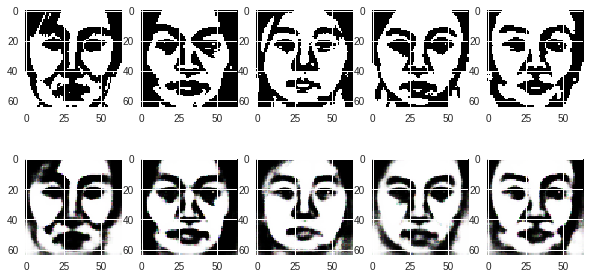

In [0]:
fig, axarr = plt.subplots(2, 5, figsize=(10,5))

for i in range(5):

  axarr[0, i].imshow(images.data.cpu()[i].numpy().reshape(3, 64, 64).transpose(1, 2, 0))
  axarr[1, i].imshow(recon_images.data.cpu()[i].numpy().reshape(3, 64, 64).transpose(1, 2, 0))
  
plt.show()

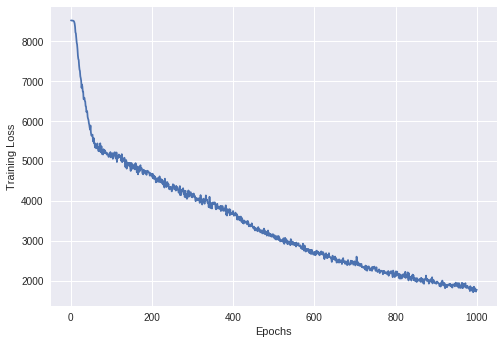

In [0]:
plt.plot(np.arange(len(loss_list))+1, loss_list)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

## 1.3: VAE with CUFS (Noisy images as input)

In [0]:
import torch
from torch.autograd import Variable
import numpy as np
import os
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
import torchvision.utils as vutils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

opt_outf = "gdrive/My Drive/CIS680/HW3/recon_images_with_noise/"
try:
    os.makedirs(opt_outf)
except OSError:
    pass


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
      
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)      

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=64):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar


def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD  
  

batch_size = 94

epochs = 1000

# Load Data
dataset = datasets.ImageFolder(root='gdrive/My Drive/CIS680/HW3/cufs/', transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), 
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

vae = VAE(image_channels=3).to(device)

optimizer = optim.Adam(vae.parameters(), lr=0.0001)

loss_list = []

for epoch in range(epochs):
  for idx, (images, _) in enumerate(dataloader):
    images = images + 0.005
    images = images.to(device)
    recon_images, mu, logvar = vae(images)
    loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  loss_list.append(loss.data[0]/batch_size)
  
  if(epoch%100 == 0):
    to_print = "Epoch[{}/{}] Loss: {:.3f} , {:.3f} , {:.3f}".format(epoch+1, epochs, loss.data[0]/batch_size, bce.data[0]/batch_size, kld.data[0]/batch_size)
    print(to_print)
    
  if(epoch%250==0 or epoch==999):
    vutils.save_image(recon_images.detach(), '%s/noise_recon_images_epoch_%03d.png' % (opt_outf, epoch), normalize=True)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch[1/1000] Loss: 8529.921 , 8529.921 , 0.000
Epoch[101/1000] Loss: 5236.298 , 5234.033 , 2.265
Epoch[201/1000] Loss: 4407.241 , 4403.049 , 4.192
Epoch[301/1000] Loss: 3746.057 , 3740.556 , 5.502
Epoch[401/1000] Loss: 3502.508 , 3495.873 , 6.635
Epoch[501/1000] Loss: 2826.831 , 2816.758 , 10.073
Epoch[601/1000] Loss: 2380.300 , 2365.070 , 15.230
Epoch[701/1000] Loss: 2111.936 , 2096.064 , 15.872
Epoch[801/1000] Loss: 1928.191 , 1913.961 , 14.230
Epoch[901/1000] Loss: 1626.388 , 1606.804 , 19.584


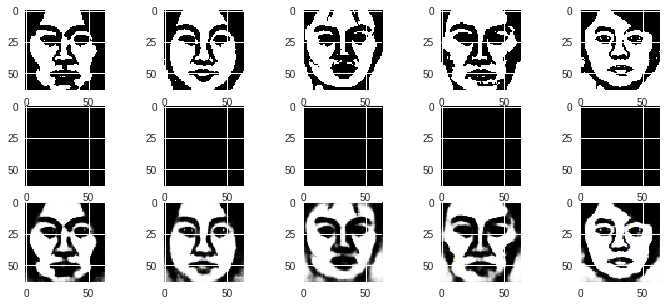

In [0]:
fig, axarr = plt.subplots(3, 5, figsize=(12,5))

for i in range(5):

  axarr[0, i].imshow((images.data.cpu()[i] - 0.005).numpy().reshape(3, 64, 64).transpose(1, 2, 0))
  axarr[1, i].imshow(images.data.cpu()[i].numpy().reshape(3, 64, 64).transpose(1, 2, 0))
  axarr[2, i].imshow(recon_images.data.cpu()[i].numpy().reshape(3, 64, 64).transpose(1, 2, 0))
  
plt.show()

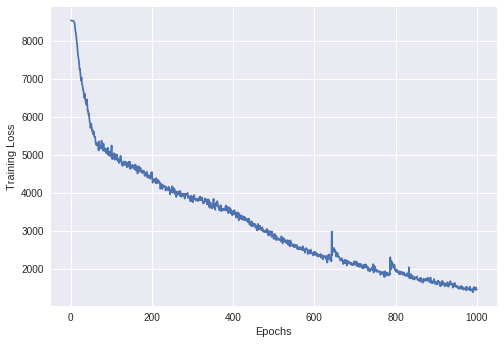

In [0]:
plt.plot(np.arange(len(loss_list))+1, loss_list)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()